# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 29th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 23 novembre 2020**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "ayoub"
ln1 = "tabaai"
fn2 = "oumaima"
ln2 = "bouther"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_tabaai_ayoub_and_bouther_oumaima.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy import linalg
import seaborn as sns
sns.set()

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] += A[:,j].dot(residuals) / lips_const[j]
        # update residuals:
        residuals += A[:,j]*old_w_j - A[:,j]*w[j]
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = np.sum(A * A, axis=0)
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(abs(gradient))
        old_w_j  = w[j]
        w[j] -= gradient[j]/lips_const[j]
        # update gradient:
        gradient += gram[:,j] * w[j] - gram[:,j] * old_w_j
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

In [6]:
# To compute a precise minimum of the prblem we will use the scipy.solve 
w_min = linalg.solve(np.dot(A.T, A), np.dot(A.T, b))

In [7]:
import time
n_iter = 10000
start_time = time.time()
w_cd , obj_cd  = cyclic_cd(A,b,n_iter)
print(" cyclic {} seconds ".format((time.time() - start_time)))
start_time = time.time()
w_gcd , obj_gcd  = greedy_cd(A,b,n_iter)
print(" greedy {} seconds ".format((time.time() - start_time)))

 cyclic 0.21087288856506348 seconds 
 greedy 0.196943998336792 seconds 


The objective function for the cyclic CD is:466.38
The objective function for the greedy CD is:466.38


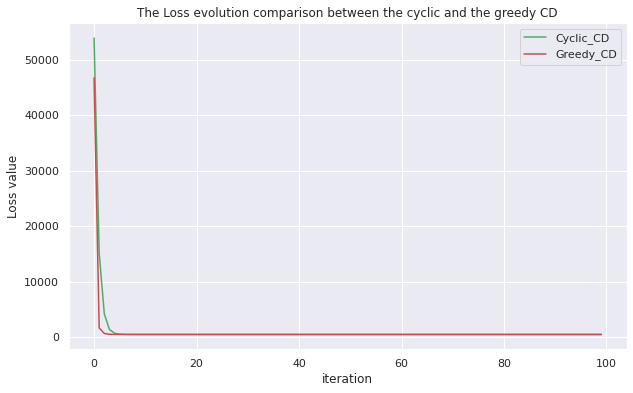

In [8]:
#Let's plot the objective value for greedy_CD and cyclic_CD
print('The objective function for the cyclic CD is:{:.2f}'.format(obj_cd[-1]))
print('The objective function for the greedy CD is:{:.2f}'.format(obj_gcd[-1]))

plt.figure(figsize=(10,6))
plt.plot(obj_cd  , 'g', label="Cyclic_CD")
plt.plot(obj_gcd , 'r',label="Greedy_CD")
plt.xlabel('iteration')
plt.ylabel('Loss value')
plt.title('The Loss evolution comparison between the cyclic and the greedy CD')
plt.legend()
plt.show()

In [9]:
#distance to the minimizer obtained with scipy solver 

print ("error for cyclic CD : "+ str(norm(w_cd-w_min, ord=2)))
print ("error for greedy CD : "+ str(norm(w_gcd-w_min, ord=2)))

error for cyclic CD : 1.4514605841808855e-14
error for greedy CD : 1.0333356683632903e-14


$\bullet$ **Comparison** : As we notice, greedy cd takes more time to make the same number of iterations as cyclic cd and this is due to more computation done by the greedy cd that computes the whole gradient and then compare its elements to choose the best direction. The objective continue to decrease for both cyclic and greedy CD algorithms to reach at the end the same value of 466.38. after 10000 iteration, the distances of the final minimizers gotten by the cyclic and the greedy algorithms from the minimzers given by the scipy solver are respectively $1.45\;10^{-14}$ and $10^{-14}$. This prove that the greedy algorithms outperforms the cyclic algorithm. This can be explained by the method of the selection of the variable that the greedy algorithm relies on. Instead of choosing in order at random or in order the components, the greedy algorithm selects a good coordinate that yields to a better reduction of the objective function, and this selection is based on the magnitude of the gradient components. Since we select the best component, this implies that at each iteration the greedy cd reduce the objective function more that the cyclic cd. This also explain why at the same number of iteration teh greedy cd take more time than the cyclic cd, where the greedy shoudl compute the whole gradient and compare all the components which takes more time.

$\bullet$**greedy CD for L2 regularized logistic regression**: For greedy cd, we shoud at each time compute the whole gradient and compare between its components which is time consuming. In the case of L2 regularized logistic regression we try to reduce the parameters but doesn't produce the sparcity which helps to reduce the number of variables and ,so, reducing the variable space dimension. Consequently, the greedy cd for the L2 regularized logistic regression would not be as efficient as the L1 regularized logistic regression.

$\bullet$**OLS with 100,000 features**: To run the greedy cd, we compute the whole gradient and compare them to pick the greater. With a such number of variable this will be inefficient and it would take a large time to make each iteration. Even if we omit the gradient computation, the comparison between 100,000 variables would be expensive.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

**Answer**:
For all funtions f and g we have : $\partial(f+g)(\omega) = \partial f(\omega) +\partial g(\omega)$.

Let $$f(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
First, let's compute the subdifferential of $f$. $f$ is differentiable which implies that it's subdifferential is exactly its gradient.

Therefore, 
$$ \partial f(w) = \sum_{i=1}^{n} \frac{-y_ix_i}{1 + e^{y_i w^\top x_i}} + \lambda \partial \Vert \cdot \Vert_1 (w)$$

Using the beautiful above result, we get : $$\partial \Vert \cdot \Vert_1 (0_p)  = 
\partial \vert \cdot \vert_1 (0) \times ... \times \partial \vert \cdot \vert_1 (0) = [-1,1]^p$$

Thus, $$ \partial f(0_p) = -\frac 12 \sum_{i=1}^{n} y_ix_i + [-\lambda,\lambda]^p $$

Also, we can see that $-\frac 12 \sum_{i=1}^{n} y_ix_i = -\frac 12 X^\top y$

Let $\frac{1}{2} X^\top y = (a_1,...,a_p)$. By definition $\frac 12 \Vert X^\top y\Vert_\infty = \max_{i}(\vert a_i \vert)$ 

Therefore, 
\begin{align}
\lambda \geq \lambda_{max} & \implies \forall i,\; \lambda \geq |a_i|  \\
& \implies \forall i,\; \lambda \geq a_i \geq -\lambda \\
 & \implies -\frac 12 X^\top y \in [-\lambda, \lambda]^p\\
 & \implies 0_p \in \partial f(0_p)
\end{align}
We have $f$ is a sum of convex functions, then it is convex. By this we have proved that $0_p \in \partial f(0_p))$ and $f$ is convex.

Then, 0 is a global minimizer of $f$. Also, by uniqueness, we get : $\hat w = 0$ 

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

**Answer**: The smooth term here is given by the following function : $$ f(w) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} ) $$

Let's define first what is the coordinate-wise Lipschitz constant of the smooth term $\gamma_j$.

Let
\begin{align*} 
  g_{j,w}:\mathbb{R} & \to \mathbb R \\
  h & \to f(w+U_jh) = f(w_1,...,w_j + h,...,w_p)
\end{align*}
By definition, $L_j = L(\nabla g_{j,w})$ and $\gamma_j = 1/L_j$ 

We have $\nabla g_{j,w} =\frac{\partial f}{\partial w_j} =  \sum_{i=1}^{n} \frac{-y_ix_{ij}}{1 + e^{y_iw^\top xi}}$.

Now to find $L_j$ we can compute the second derivative of $g_{j,w}$ and find an upper bound of it which would be our $L_j$.

We have $g_{j,w}$ depends only on the jth element of $w$. Therefore, 
$$\nabla^2 g_{j,w} = \frac{\partial^2 f}{\partial w_j^2} = \sum_{i=1}^{n} \frac{x_{ij}^2(e^{y_iw^\top xi})}{(1 + e^{y_iw^\top xi})^2}$$

Let $z_i(w) = \frac{1}{1 + e^{y_iw^\top xi}} \in ]0,1[$.

We have $$\nabla^2 g_{j,w} = \sum_{i=1}^{n}x_{ij}^2 z_i(w)(1 - z_i(w))$$

We know that $\forall x \in [0,1],\; x(1 - x) \leq \frac 14 \implies  \; z_i(w)(1 - z_i(w)) \leq \frac 14 \;\;\; \forall i,w$

Therfore, $$ \nabla^2 g_{j,w} \leq \frac 14 \sum_{i=1}^{n}x_{ij}^2 = \frac 14 \Vert X_j \Vert ^2$$


Thus , $\gamma_j = 4/\Vert X_j \Vert ^2$.

<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [10]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    all_objs = np.zeros(n_iter)

    # TODO
    lips_const = [norm(X[:,i] , ord=2)**2 / 4 for i in range(n_features)]
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = -sum([y[i] * X[i,j] * sigmoid(-y[i]*Xw[i]) for i in range(n_samples)]) 
            w[j] = soft_thresh(old_w_j - grad_j/lips_const[j], lamb/lips_const[j])
            
            if old_w_j != w[j]:
              Xw += w[j] * X[:,j] - old_w_j * X[:,j] 
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [11]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [12]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

In [13]:
#In this part we will use some materials from the first lab to implement the ISTA algorithm.   

def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x""" 
    a = np.sign(x)*np.maximum(np.abs(x)-lmbd, 0)
    return a # TODO
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*np.sum(np.abs(x)) # TODO

def loss_logreg(x):
    """Logistic loss"""
    # TODO
    n = X.shape[0]
    return sum([np.log(1 + np.exp(-y[i]*np.dot(X[i],x))) for i in range(n)])

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    return -sum([y[i] * X[i,:] * sigmoid(-y[i]*X[i].dot(x)) for i in range(X.shape[0])]) 

def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    # TODO
    L = 1/4*(np.linalg.norm(A,2)**2)
    return L
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = X.shape

    # objective history
    objectives = []
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]]))
    for k in range(n_iter + 1):

        #### TODO #### 
        x = prox_R(x - step*grad_f(x),lmbd*step)      
        obj = f(x) + R(x, lmbd)
        objectives.append(obj)
        if k % 10000 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), ("%.2e" % obj).rjust(8)]))
    return x, objectives

In [14]:
# ISTA results
n_iter = 10
n_sample, n_feature = X.shape
x0 = np.zeros(n_feature)
w_min_ista, obj_ista = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, 1/smoothness_const_loreg(X), lmbd=lambd, n_iter=n_iter*n_feature, verbose=True)

Lauching PGDsolver...
   it    |   obj   
       0 | 4.93e+01
   10000 | 4.82e+01
   20000 | 4.82e+01
   30000 | 4.82e+01
   40000 | 4.82e+01
   50000 | 4.82e+01
   60000 | 4.82e+01
   70000 | 4.82e+01


In [15]:
# Proximal coordinate descent results 
w_prox_cd, obj_prox_cd = cd_logreg(X, y, lambd, n_iter)

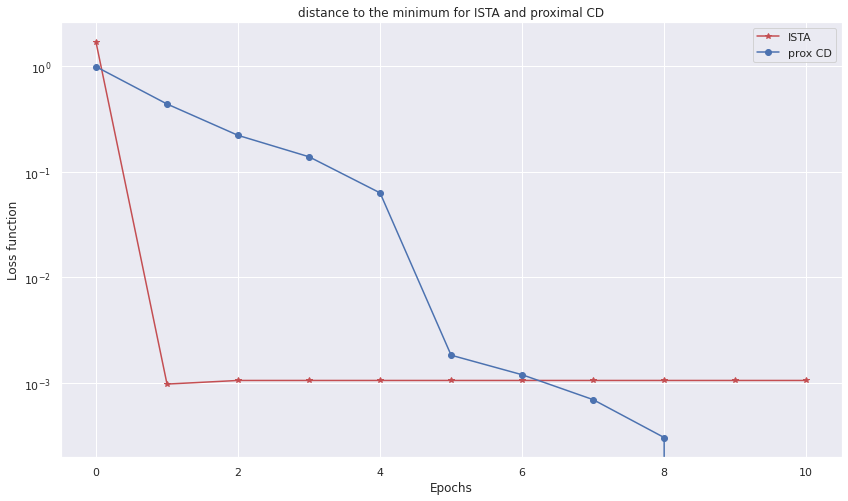

In [16]:
# comparing the performances of proximal coordinate and ista
prox_obj = [norm(obj-obj_prox_cd[-1] ) for obj in obj_prox_cd]
ista_obj = [norm(obj-obj_prox_cd[-1] ) for obj in obj_ista[::n_feature]]

plt.figure(figsize=(14,8))
plt.semilogy(ista_obj, 'r*-', label="ISTA")
plt.semilogy(prox_obj, 'o-',label="prox CD")
plt.title('distance to the minimum for ISTA and proximal CD')
plt.xlabel('Epochs')
plt.ylabel('Loss function')

plt.legend()
plt.show()